In [2]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt
import os

In [4]:
def loss_fn(x_m, a_m, alpha_m):
    return cp.norm2(x_m - cp.matmul(a_m, alpha_m))**2

def regularizer_1(alpha_m):
    return cp.norm1(alpha_m)

def regularizer_2(alpha_m):
    return cp.norm2(alpha_m)

def objective_fn(x_m, a_m, alpha_m, lambd_1, lambd_2):
    return loss_fn(x_m, a_m, alpha_m) + lambd_1 * regularizer_1(alpha_m) + lambd_2 * (regularizer_2(alpha_m) ** 2)

def mse(x_m, a_m, alpha_m):
    return (1.0 / a_m.shape[0]) * loss_fn(x_m, a_m, alpha_m).value

def gen_mtrx(A , i):
    dims = A.shape
    A_m = np.copy(A)
    X_m = np.copy(A[: , i])
    zeros = np.zeros(dims[0])
    A_m[: , i] = zeros
    return X_m , A_m

def couple_coeff(X_m,A_m,lambd_1,lambd_2):
    alpha_m = cp.Variable(A_m.shape[1])
    problem = cp.Problem(cp.Minimize(objective_fn(X_m, A_m, alpha_m, lambd_1, lambd_2)))
    problem.solve()
    return alpha_m.value[np.newaxis].T

def test_lambd_1(X_train, A_train, X_test, A_test):
    alpha_m = cp.Variable(A_train.shape[1])
    lambd_1 = cp.Parameter(nonneg=True)
    lambd_1_values = np.logspace(-2, 3, 50)
    problem = cp.Problem(cp.Minimize(objective_fn(X_train , A_train , alpha_m , lambd_1)))

    train_errors = []
    test_errors = []
    alpha_values = []

    for v in lambd_1_values:
        lambd_1.value = v
        problem.solve()
        train_errors.append(mse(X_train, A_train, alpha_m))
        test_errors.append(mse(X_test, A_test, alpha_m))
        alpha_values.append(alpha_m.value)
    return train_errors, test_errors, lambd_1_values

def test_lambd_2(X_train, A_train, X_test, A_test, lambd_1):
    alpha_m = cp.Variable(A_train.shape[1])
    lambd_2 = cp.Parameter(nonneg=True)
    lambd_2_values = np.logspace(-2, 3, 50)
    problem = cp.Problem(cp.Minimize(objective_fn(X_train , A_train , alpha_m , lambd_1, lambd_2)))

    train_errors = []
    test_errors = []
    alpha_values = []

    for v in lambd_2_values:
        lambd_2.value = v
        problem.solve()
        train_errors.append(mse(X_train, A_train, alpha_m))
        test_errors.append(mse(X_test, A_test, alpha_m))
        alpha_values.append(alpha_m.value)
    return train_errors, test_errors, lambd_2_values

def plot_train_test_errors(train_errors, test_errors, lambd_2_values):
    plt.plot(lambd_2_values, train_errors, label="Train error")
    plt.plot(lambd_2_values, test_errors, label="Test error")
    plt.xscale("log")
    plt.legend(loc="upper left")
    plt.xlabel(r"$\lambda_{2}$", fontsize=16)
    plt.title("Mean Squared Error (MSE)")
    plt.show()

def time_series_loader(root):
    ts_list = sorted(os.listdir(root))
    ts_path_list = []
    for i in range(0, len(ts_list)):
            ts_path_list.append(os.path.join(root, ts_list[i]))
    return ts_path_list

def generate_hypergraph(ts, lambd_1, lambd_2):
    alpha_list = []
    for i in range(ts.shape[1]):
        X_m , A_m = gen_mtrx(ts , i)
        alpha = couple_coeff(X_m, A_m, lambd_1 , lambd_2 )
        alpha_list.append(alpha)
    alpha_array = np.concatenate(alpha_list, axis=1)
    np.fill_diagonal(alpha_array, 1)
    assert alpha_array.shape[0] == alpha_array.shape[1]
    return alpha_array

def threshold_hypergraph(hypergraph, threshold):
    for i in range(hypergraph.shape[0]):
        for j in range(hypergraph.shape[1]):
            if abs(hypergraph[i,j]) < threshold:
                hypergraph[i , j] = 0
            else:
                hypergraph[i , j] = 1
    return hypergraph

def save_hypergraph(hypergraph,directory,method,threshold,lambd_1, lambd_2,id):
    dir = f'{directory}/{method}/thresh_{threshold}_lambda_1_{lambd_1}_lambda_2_{lambd_2}'
    if not os.path.exists(dir):
        os.makedirs(dir)
    np.savetxt(f'{dir}/{id}_{method}_{threshold}.csv', hypergraph, delimiter=',')
    return

def train_test_split(X_m , A_m, train_pct):
    dims = A_m.shape
    train_pct = train_pct
    train_split = int(train_pct * dims[0])
    X_train = X_m[:train_split]
    X_test = X_m[train_split:]
    A_train = A_m[:train_split, :]
    A_test = A_m[train_split:, :]
    return X_train, X_test, A_train, A_test

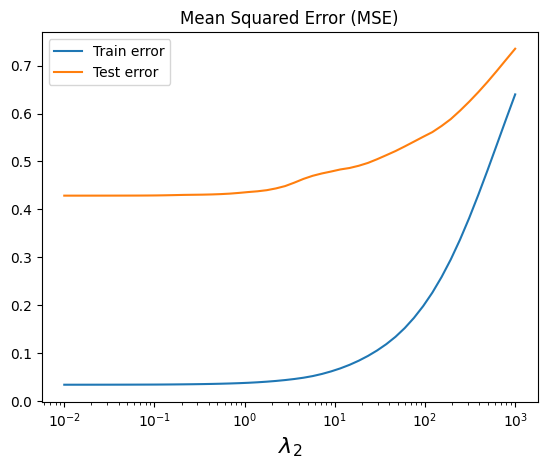

In [8]:
time_series_list = time_series_loader('ADNI_gsr/time_series')
id = time_series_list[15][-14:-4]
time_series = np.loadtxt(time_series_list[0], delimiter=',')
minimum_error_lambda = []
#for i in range(116):
X_m, A_m = gen_mtrx(time_series, 78)
X_train, X_test, A_train, A_test = train_test_split(X_m, A_m, 0.8)
train_errors, test_errors, lambd_2_values = test_lambd_2(X_train, A_train, X_test, A_test, 1)
#minimum_error_lambda.append(lambd_2_values[test_errors.index(min(test_errors))])
plot_train_test_errors(train_errors, test_errors, lambd_2_values)
#print(minimum_error_lambda)

In [12]:
lambd_1 = 1
lambd_2 = 0.1
threshold = 0.5
time_series_list = time_series_loader('ADNI_gsr/time_series')
for i in range(len(time_series_list)):
    id = time_series_list[i][-14:-4]
    time_series = np.loadtxt(time_series_list[i], delimiter=',')
    hg = generate_hypergraph(time_series, lambd_1, lambd_2)
    hg_thresh = threshold_hypergraph(hg, threshold)
    save_hypergraph( hg_thresh , 'ADNI_gsr/hypergraphs' , 'elastic_net' ,threshold, lambd_1 , lambd_2, id)